## Performance Baseline

In this notebook we establish our validation process and performance baseline.

In [3]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')

ds.data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,MSP,DayOfYear,HourEnding,IsBusinessHour,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,,,
2015-02-01 00:00:00-05:00,23.00,32,1,0,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,32,2,0,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,32,3,0,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,32,4,0,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,32,5,0,10432,10700.09


In [8]:
ds.features

['MSP', 'DayOfYear', 'HourEnding', 'IsBusinessHour']

### Similar Days Heuristic

In common practice, similar days are used to develop predictors. A
similar day is determined using similarity characteristics such as:
* weather,
* day of week,
* date,
* holidays,
* etc.

This practice reflects the intuition that the shape of a load curve is unlikely
to be highly dissimilar from any prior load curve. Using a regression procedure,
a number of similar days can be used instead of a single day.

### Naive Similarity
However, in our naive baseline model, we will simply use `k`-nearest neighbors from preceding hours. We will compare this baseline against competing models.

### Walk Forward Validation

Our `walkforward` function predicts each day, incorporating all previous days from the training+validation set.

In [9]:
from validation import Error, walkforward
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

for k in range(3, 16):
    knn = KNeighborsRegressor(k, weights='distance')
    (predictions, errors) = walkforward(knn, ds.data, ds.data[ds.actual],
                                        ds.validation_start, ds.validation_end, lambda X,r,yhat: r, ds.features)
    overall_error = Error(ds.validation_data[ds.actual], np.concatenate(predictions))
    print(overall_error)

Error(mae=1156.2029315688387, max=5381.859691211401, total=10128337.680542987)
Error(mae=1162.740584542442, max=5532.5264750321585, total=10185607.520591773)
Error(mae=1165.1386094886673, max=5523.334108035571, total=10206614.219120765)
Error(mae=1167.8490723291366, max=5578.143035823317, total=10230357.873603264)
Error(mae=1169.1902278141436, max=5610.352151205161, total=10242106.395651896)
Error(mae=1172.214183026149, max=5638.709948356278, total=10268596.243309055)
Error(mae=1173.6877502339037, max=5675.873144212355, total=10281504.69204898)
Error(mae=1175.1075545274396, max=5683.031119503426, total=10293942.177660367)
Error(mae=1176.338920825644, max=5691.40911448037, total=10304728.946432648)
Error(mae=1176.92442963744, max=5684.743539708616, total=10309858.003624022)
Error(mae=1177.4896531818451, max=5692.241351599796, total=10314809.361873)
Error(mae=1178.8882757201486, max=5683.590953101579, total=10327061.29530855)
Error(mae=1179.976341850048, max=5667.404711718835, total=1033

It appears `k = 13` gives the best result in this naive model, but this is still 3 times the MAE of the MISO MTLF and about 1.5 times its max error.

In [10]:
mtlf_error = Error(ds.validation_data[ds.actual], ds.validation_data[ds.mtlf])
print(f'MTLF {mtlf_error}')

MTLF Error(mae=222.98570091324197, max=2217.33, total=1953354.7399999993)


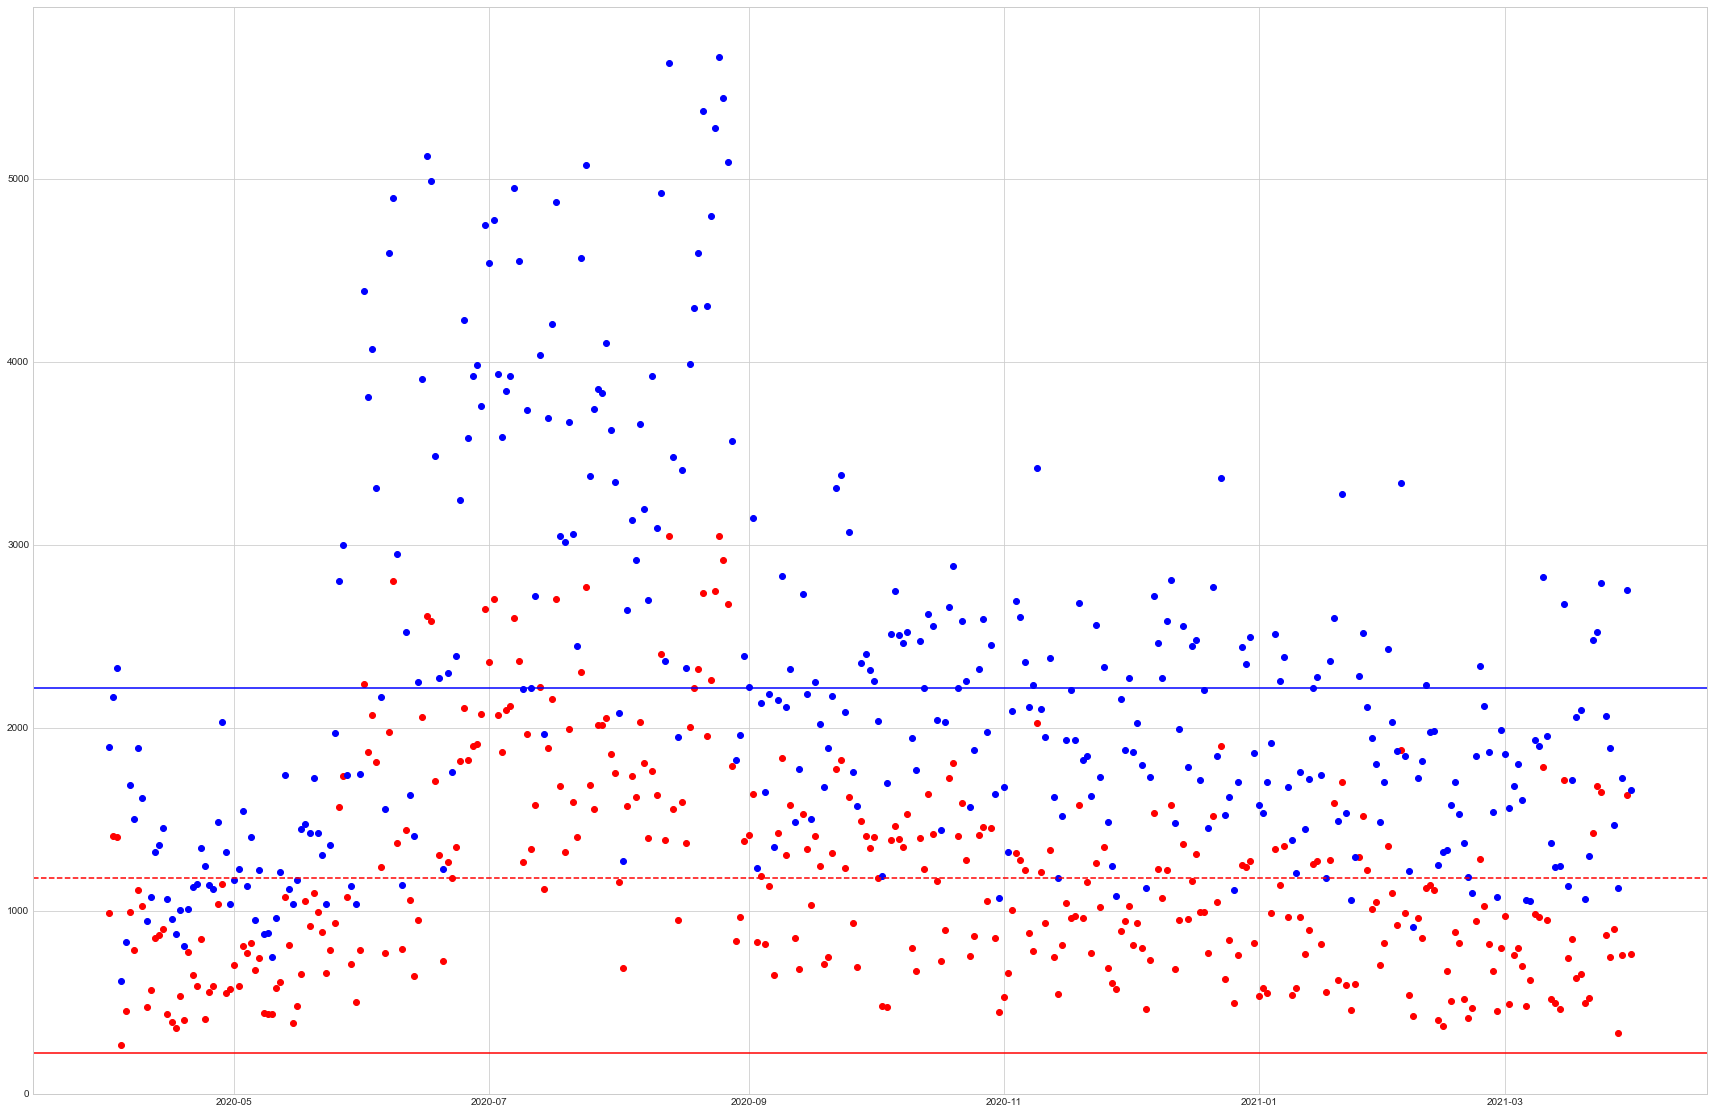

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

mae = [e.mae for e in errors]
maxe = [e.max for e in errors]
dates = ds.validation_data.index.to_series()[::24].array
plt.figure(figsize=(30, 20))
plt.plot(dates, mae, 'ro', dates, maxe, 'bo')
plt.axhline(y=mtlf_error.mae, color='r', linestyle='-')
plt.axhline(y=overall_error.mae, color='r', linestyle='--')
plt.axhline(y=mtlf_error.max, color='b', linestyle='-')
plt.show()

### Observations and Next Steps

While it is promising that there is a slight trend toward lower error as more data is made available, we are still well above the MTLF MAE nearly every day and exceed the MTLF maximum error quite frequently. To be competitive, we should aim to have a lower MAE and a lower maximum error on the test set.

Next we will explore additional features that will give us a richer similarity heuristic and allow us to employ regression methods.